# Cryptocurrency Price Analysis using Autoencoders

In [1]:
import os, math, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, f1_score, roc_auc_score
import umap

/data/user/home/dmelkani/Human_Sleep_Data/hs_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 28
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
card_df = pd.read_csv('card_transdata.csv')
crypto_df = pd.read_csv('crypto_markets.csv')

print(f"card_df shape: {card_df.shape}")
print(f"crypto_df shape: {crypto_df.shape}")

card_df shape: (1000000, 8)
crypto_df shape: (942297, 13)


In [4]:
display(card_df)
display(crypto_df)
# print(f"card_df:\n\n{card_df.head()}\n\n")
# print(f"crypto_df:\n\n{crypto_df.head()}")

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
942292,project-x,NANOX,Project-X,2018-11-26,1727,22424.60,23049.30,17607.50,20724.80,143.0,1.622000e+03,0.5728,5441.80
942293,project-x,NANOX,Project-X,2018-11-27,1727,20711.90,23742.10,19292.90,23298.70,637.0,1.823000e+03,0.9003,4449.20
942294,project-x,NANOX,Project-X,2018-11-28,1727,23320.90,25235.10,19888.10,24442.70,49.0,1.913000e+03,0.8518,5347.00
942295,project-x,NANOX,Project-X,2018-11-29,1727,24543.53,24582.47,21457.95,22839.44,153.0,1.788000e+03,0.4421,3124.52


In [5]:
crypto_df['date'] = pd.to_datetime(crypto_df['date'])

# Basic derived columns for EDA
crypto_df['spread'] = crypto_df['high'] - crypto_df['low']
crypto_df['return'] = crypto_df.groupby('slug')['close'].pct_change()
crypto_df['log_return'] = np.log1p(crypto_df['return'].clip(lower=-0.9999))

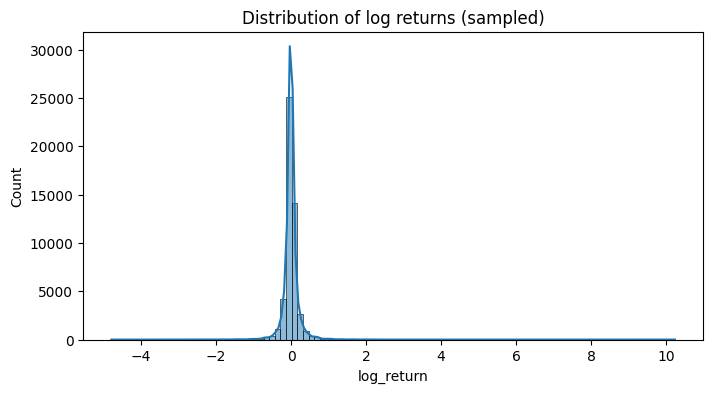

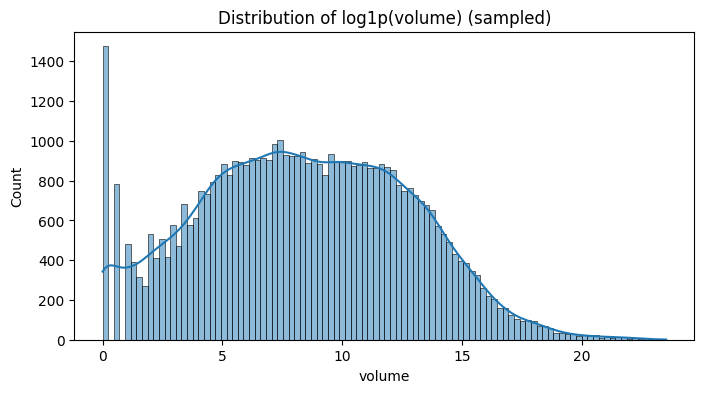

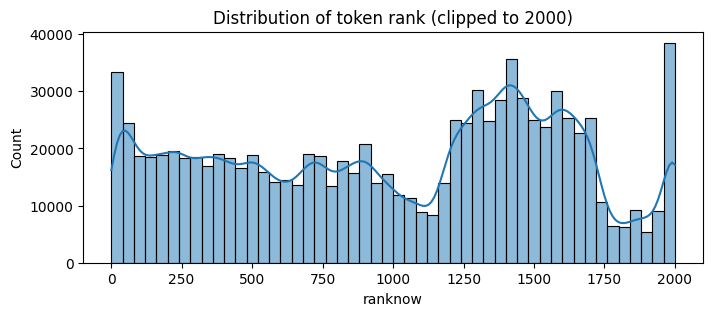

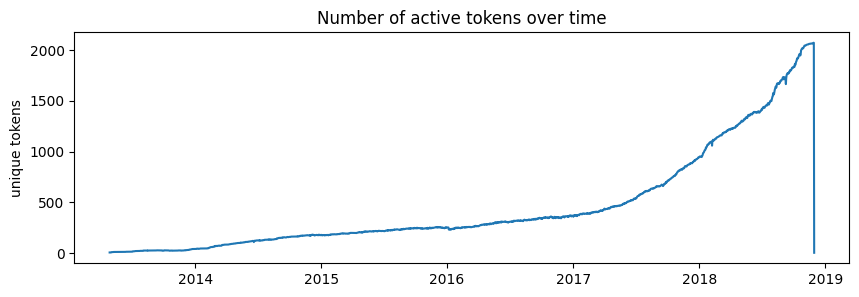

In [6]:
# 1. Quick EDA visuals (distributions of returns, volume, rank) for crypto_df

# histogram of returns (sample so plotting is fast)
sample = crypto_df['log_return'].replace([np.inf, -np.inf], np.nan).dropna().sample(n=50000, random_state=SEED)
plt.figure(figsize=(8,4))
sns.histplot(sample, bins=100, kde=True)
plt.title('Distribution of log returns (sampled)')
plt.xlabel('log_return')
plt.show()

# volume distribution (log scale)
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(crypto_df['volume'].clip(lower=0)).sample(n=50000, random_state=SEED), bins=100, kde=True)
plt.title('Distribution of log1p(volume) (sampled)')
plt.show()

# rank distribution
plt.figure(figsize=(8,3))
sns.histplot(crypto_df['ranknow'].clip(upper=2000), bins=50, kde=True)  # clip for readability
plt.title('Distribution of token rank (clipped to 2000)')
plt.show()

# time coverage (how many tokens over time)
tokens_over_time = crypto_df.groupby('date')['slug'].nunique().reset_index()
plt.figure(figsize=(10,3))
plt.plot(tokens_over_time['date'], tokens_over_time['slug'])
plt.title('Number of active tokens over time')
plt.ylabel('unique tokens')
plt.show()

In [ ]:
# 2. Preprocessing & Feature Engineering (fixes included)

# ensure date is datetime and sort
crypto_df['date'] = pd.to_datetime(crypto_df['date'])
crypto_df = crypto_df.sort_values(['slug','date']).reset_index(drop=True)

# drop rows where all price columns are NaN
price_cols = ['open','high','low','close']
crypto_df = crypto_df.dropna(subset=price_cols, how='all')

# keep tokens with at least 30 days of data
token_lengths = crypto_df.groupby('slug')['date'].count()
valid_tokens = token_lengths[token_lengths >= 30].index
crypto_df = crypto_df[crypto_df['slug'].isin(valid_tokens)].reset_index(drop=True)
print("After filtering tokens with >= 30 days:", crypto_df.shape)

# derived features
crypto_df['spread'] = crypto_df['high'] - crypto_df['low']
crypto_df['close_ratio'] = (crypto_df['close'] - crypto_df['low']) / (crypto_df['high'] - crypto_df['low'] + 1e-9)

# returns and log returns (clipped to avoid -inf)
crypto_df['return'] = crypto_df.groupby('slug')['close'].pct_change()
crypto_df['log_return'] = np.log1p(crypto_df['return'].clip(lower=-0.9999))

# rolling features with min_periods=1 to avoid NaNs at start
for window in [7, 30]:
    crypto_df[f'rolling_std_{window}'] = crypto_df.groupby('slug')['log_return'].transform(
        lambda x: x.rolling(window, min_periods=1).std()
    )
    crypto_df[f'rolling_mean_ret_{window}'] = crypto_df.groupby('slug')['log_return'].transform(
        lambda x: x.rolling(window, min_periods=1).mean()
    )
    crypto_df[f'rolling_vol_{window}'] = crypto_df.groupby('slug')['volume'].transform(
        lambda x: x.rolling(window, min_periods=1).mean()
    )

# token age and cyclical features (optional)
crypto_df['token_age'] = crypto_df.groupby('slug')['date'].transform(lambda x: (x - x.min()).dt.days)
crypto_df['dayofweek'] = crypto_df['date'].dt.dayofweek
crypto_df['month'] = crypto_df['date'].dt.month

# log transforms for heavy-tailed features
for col in ['open','high','low','close','volume','market']:
    crypto_df[f'log1p_{col}'] = np.log1p(crypto_df[col].clip(lower=0))

# forward/backfill short gaps per token - use group_keys=False to avoid future deprecation issues
crypto_df = crypto_df.groupby('slug', group_keys=False).apply(lambda g: g.ffill().bfill()).reset_index(drop=True)

print("Post-engineering shape:", crypto_df.shape)

After filtering tokens with >= 30 days: (941490, 15)


/scratch/local/ipykernel_12467/2176212639.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crypto_df = crypto_df.groupby('slug', group_keys=False).apply(lambda g: g.ffill().bfill()).reset_index(drop=True)


Post-engineering shape: (941490, 30)


In [ ]:
# 3. Build datasets: day-level and sliding-window (we will train on sliding windows)

day_features = [
    'log1p_open','log1p_high','log1p_low','log1p_close',
    'log1p_volume','log1p_market',
    'close_ratio','spread','ranknow',
    'log_return','rolling_std_7','rolling_std_30',
    'rolling_mean_ret_7','rolling_mean_ret_30',
    'rolling_vol_7','rolling_vol_30',
    'token_age','dayofweek','month'
]

# drop rows with NaNs in the selected features
day_df = crypto_df.dropna(subset=day_features).copy()
print("Day-level rows:", len(day_df))

# standardize features (dataset-level scaler; fit on all for now; for strict leakage avoidance, fit only on train)
scaler_day = StandardScaler()
X_day = scaler_day.fit_transform(day_df[day_features])
print("X_day shape:", X_day.shape)

# sliding-window builder (window length L, stride)
def make_sliding_windows(df, features, L=30, stride=1, max_windows=None):
    X, meta = [], []
    for token, g in df.groupby('slug'):
        g = g.sort_values('date')
        values = g[features].values  # already numeric
        dates = g['date'].values
        n = len(values)
        for i in range(0, n - L + 1, stride):
            window = values[i:i+L]
            # only include windows with no NaNs
            if np.isnan(window).sum() == 0:
                X.append(window.flatten())
                meta.append((token, dates[i]))
            if max_windows is not None and len(X) >= max_windows:
                return np.array(X), pd.DataFrame(meta, columns=['token','date'])
    return np.array(X), pd.DataFrame(meta, columns=['token','date'])

# for development, you can set max_windows to a smaller number. Set to None for full dataset.
max_windows = None  # or e.g., 100000 for faster dev
SEQ_LEN = 30
X_win, meta_win = make_sliding_windows(day_df, day_features, L=SEQ_LEN, stride=1, max_windows=max_windows)
print("Sliding-window matrix shape (flattened):", X_win.shape)
print(meta_win.head())

# scale windows (dataset-level)
scaler_win = StandardScaler()
X_win = scaler_win.fit_transform(X_win)  # shape (N_windows, L * F)

# compute dims for models
num_features = len(day_features)
seq_len = SEQ_LEN
input_dim = seq_len * num_features
print("input_dim:", input_dim, "num_features:", num_features, "seq_len:", seq_len)

Day-level rows: 941490
X_day shape: (941490, 19)
Sliding-window matrix shape (flattened): (882649, 570)
    token       date
0  0chain 2018-07-02
1  0chain 2018-07-03
2  0chain 2018-07-04
3  0chain 2018-07-05
4  0chain 2018-07-06
input_dim: 570 num_features: 19 seq_len: 30


In [9]:
# 4. Build PyTorch Datasets & DataLoaders (train/val/test splits)
#    We'll do a time-aware split per token: earliest windows -> train, later -> val/test
#    Simpler approach: global sequential split by index to preserve temporal ordering.

N = X_win.shape[0]
train_frac, val_frac = 0.80, 0.10
n_train = int(N * train_frac)
n_val = int(N * val_frac)
n_test = N - n_train - n_val

# Shuffle indices but preserve relative time order within shuffle? For simplicity, do sequential split (time-based)
indices = np.arange(N)
train_idx = indices[:n_train]
val_idx = indices[n_train:n_train+n_val]
test_idx = indices[n_train+n_val:]

X_train = torch.tensor(X_win[train_idx], dtype=torch.float32)
X_val   = torch.tensor(X_win[val_idx], dtype=torch.float32)
X_test  = torch.tensor(X_win[test_idx], dtype=torch.float32)

meta_train = meta_win.iloc[train_idx].reset_index(drop=True)
meta_val = meta_win.iloc[val_idx].reset_index(drop=True)
meta_test = meta_win.iloc[test_idx].reset_index(drop=True)

# For Conv1DAE we need shape (B, L, F) -> convert on the fly in collate_fn or provide separate datasets
def to_sequence_tensor(X_flat, seq_len, num_feat):
    return X_flat.view(-1, seq_len, num_feat)  # expects X_flat to be (B, L*F)

# Create TensorDataset with metadata included as arrays of token/date strings
def make_dataloader(X_tensor, meta_df, batch_size=256, shuffle=True):
    # meta: list of tuples
    tokens = meta_df['token'].values
    dates = meta_df['date'].astype(str).values
    # pack as Tensors for DataLoader; meta will be returned as python objects
    ds = TensorDataset(X_tensor, torch.arange(len(tokens)))  # placeholder index
    loader = DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False)
    # We will map batch indices to meta inside extraction functions using the meta_df
    return loader, (tokens, dates)

BATCH_SIZE = 256
train_loader, train_meta = make_dataloader(X_train, meta_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader, val_meta = make_dataloader(X_val, meta_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader, test_meta = make_dataloader(X_test, meta_test, batch_size=BATCH_SIZE, shuffle=False)

print("Train/Val/Test sizes:", len(X_train), len(X_val), len(X_test))
print("Example meta (train):", train_meta[0][:5])

Train/Val/Test sizes: 706119 88264 88266
Example meta (train): ['0chain' '0chain' '0chain' '0chain' '0chain']


In [ ]:
# 5. Model definitions (AE, VAE, DAE, Conv1DAE) - copied/adjusted to work with flattened windows

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

class AE(nn.Module):
    def __init__(self, input_dim, z_dim=32, h1=512, h2=256):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, h1), nn.ReLU(),
            nn.Linear(h1, h2), nn.ReLU(),
            nn.Linear(h2, z_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h2), nn.ReLU(),
            nn.Linear(h2, h1), nn.ReLU(),
            nn.Linear(h1, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)
        return x_rec, z

class VAE(nn.Module):
    def __init__(self, input_dim, z_dim=32, h1=512, h2=256, logvar_min=-10., logvar_max=10.):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.mu = nn.Linear(h2, z_dim)
        self.logvar = nn.Linear(h2, z_dim)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h2), nn.ReLU(),
            nn.Linear(h2, h1), nn.ReLU(),
            nn.Linear(h1, input_dim)
        )
        self.logvar_min = logvar_min
        self.logvar_max = logvar_max

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.mu(h)
        logvar = self.logvar(h)
        # clamp logvar to avoid overflow in exp
        logvar = torch.clamp(logvar, self.logvar_min, self.logvar_max)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # logvar already clamped in encode
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        # Guard against NaNs/Infs
        z = torch.nan_to_num(z, nan=0.0, posinf=torch.finfo(z.dtype).max, neginf=-torch.finfo(z.dtype).max)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_rec = self.decoder(z)
        return x_rec, mu, logvar, z

class DAE(AE):
    def __init__(self, input_dim, z_dim=32, h1=512, h2=256, noise_factor=0.1):
        super(DAE, self).__init__(input_dim, z_dim, h1, h2)
        self.noise_factor = noise_factor
    def add_noise(self, x):
        return x + torch.randn_like(x) * self.noise_factor
    def forward(self, x, add_noise=True):
        if add_noise:
            x = self.add_noise(x)
        return super().forward(x)


class Conv1DAE(nn.Module):
    # Encoder expects input (B, L, F) and will internally transpose to (B, F, L)
    def __init__(self, num_features, seq_length, z_dim=32):
        super(Conv1DAE, self).__init__()
        self.seq_length = seq_length
        # encoder conv stack
        self.encoder = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # output shape (B, 32, 1)
        )
        self.fc_mu = nn.Linear(32, z_dim)
        self.fc_logvar = nn.Linear(32, z_dim)
        # decoder
        self.decoder_fc = nn.Linear(z_dim, 32 * seq_length)
        self.decoder_conv = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, num_features, kernel_size=3, padding=1)
        )
    def encode(self, x):
        # x: (B, L, F) -> transpose (B, F, L)
        x = x.transpose(1,2)
        h = self.encoder(x).squeeze(-1)  # (B, 32)
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = self.decoder_fc(z)  # (B, 32*L)
        # use reshape instead of view to handle non-contiguous tensors robustly
        h = h.reshape(-1, 32, self.seq_length)  # (B, 32, L)
        x_rec = self.decoder_conv(h)  # (B, F, L)
        return x_rec.transpose(1,2)  # (B, L, F)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_rec = self.decode(z)
        return x_rec, mu, logvar, z

Device: cuda


Autoencoder Reconstruction Loss: 
$$\mathcal{L}_{\text{MSE}} = \frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{x}_i)^2$$

Sigmoid Activation Function:
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

Binary Cross-Entropy Loss:
$$\mathcal{L}_{\text{BCE}} = -\frac{1}{n} \sum_{i=1}^{n} [y_i \log(p_i) + (1-y_i) \log(1-p_i)]$$

Anomaly Score:
$$s_i = \| \mathbf{x}_i - \mathbf{\hat{x}}_i \|^2$$

In [11]:
# 6. Training / validation / evaluation helpers

def mse_batch(x_rec, x, reduction='mean'):
    if reduction == 'mean':
        return F.mse_loss(x_rec, x, reduction='mean')
    elif reduction == 'sum':
        return F.mse_loss(x_rec, x, reduction='sum')
    else:
        return F.mse_loss(x_rec, x, reduction='none')

# def vae_kl(mu, logvar):
#     return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def vae_kl(mu, logvar, reduction='batch'):  # return scalar normalized by batch
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    if reduction == 'batch':
        # normalize by batch size
        return kl
    return kl

def train_one_model(model, train_loader, val_loader, model_type='AE',
                    num_epochs=50, lr=1e-3, beta=1.0, noise_factor=0.1,
                    device='cuda', seq_shape=None, save_path=None, verbose=True):
    """Train a single model on provided DataLoaders.
       train_loader/test_loader yield (X_flat_tensor, idx_tensor) where idx is placeholder index.
       seq_shape: (seq_len, num_features) if model needs sequence input (Conv1DAE).
    """
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    best_val = float('inf')
    best_state = None
    train_losses, val_losses = [], []

    for epoch in tqdm(range(num_epochs), desc=f"Model: {model_type}"):
        model.train()
        running = 0.0
        n_seen = 0
        for batch in train_loader:
            x_flat, idx = batch  # x_flat shape (B, input_dim)
            x_flat = x_flat.to(device)
            if seq_shape is not None and model_type == 'Conv1DAE':
                # reshape to (B, L, F)
                # x_in = x_flat.view(-1, seq_shape[0], seq_shape[1])
                x_in = x_flat.reshape(-1, seq_shape[0], seq_shape[1])
            else:
                x_in = x_flat

            optim.zero_grad()
            if model_type == 'AE':
                x_rec, z = model(x_in)
                loss = mse_batch(x_rec, x_in, reduction='sum')
            elif model_type == 'DAE':
                x_rec, z = model(x_in, add_noise=True)
                loss = mse_batch(x_rec, x_in, reduction='sum')
            elif model_type == 'VAE':
                x_rec, mu, logvar, z = model(x_in)
                # recon = mse_batch(x_rec, x_in, reduction='sum')
                # kl = vae_kl(mu, logvar)
                # loss = recon + beta * kl
                batch_size = x_in.size(0)
                recon = F.mse_loss(x_rec, x_in, reduction='sum') / batch_size
                kl = vae_kl(mu, logvar) / batch_size
                loss = recon + beta * kl
                
            elif model_type == 'Conv1DAE':
                x_rec, mu, logvar, z = model(x_in)
                recon = mse_batch(x_rec, x_in, reduction='sum')
                kl = vae_kl(mu, logvar)
                loss = recon + beta * kl
            else:
                raise ValueError("Unknown model_type")

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            if torch.isnan(loss) or torch.isinf(loss):
                print("Warning: loss is NaN or Inf — skipping this batch")
                optim.zero_grad()
                continue
            optim.step()
            running += loss.item()
            n_seen += x_flat.size(0)

        train_epoch_loss = running / n_seen
        train_losses.append(train_epoch_loss)

        # Validation
        model.eval()
        running_val = 0.0
        n_seen_val = 0
        with torch.no_grad():
            for batch in val_loader:
                x_flat, idx = batch
                x_flat = x_flat.to(device)
                if seq_shape is not None and model_type == 'Conv1DAE':
                    # x_in = x_flat.view(-1, seq_shape[0], seq_shape[1])
                    x_in = x_flat.reshape(-1, seq_shape[0], seq_shape[1])
                else:
                    x_in = x_flat

                if model_type == 'AE':
                    x_rec, z = model(x_in)
                    loss = mse_batch(x_rec, x_in, reduction='sum')
                elif model_type == 'DAE':
                    x_rec, z = model(x_in, add_noise=False)
                    loss = mse_batch(x_rec, x_in, reduction='sum')
                elif model_type == 'VAE':
                    x_rec, mu, logvar, z = model(x_in)
                    # recon = mse_batch(x_rec, x_in, reduction='sum')
                    # kl = vae_kl(mu, logvar)
                    # loss = recon + beta * kl

                    batch_size = x_in.size(0)
                    recon = F.mse_loss(x_rec, x_in, reduction='sum') / batch_size
                    kl = vae_kl(mu, logvar) / batch_size
                    loss = recon + beta * kl
                    
                elif model_type == 'Conv1DAE':
                    x_rec, mu, logvar, z = model(x_in)
                    recon = mse_batch(x_rec, x_in, reduction='sum')
                    kl = vae_kl(mu, logvar)
                    loss = recon + beta * kl

                running_val += loss.item()
                n_seen_val += x_flat.size(0)

        val_epoch_loss = running_val / n_seen_val
        val_losses.append(val_epoch_loss)
        print(f"\n\nTrain Loss: {train_epoch_loss}\nValidation Loss: {val_epoch_loss}\n")
        if val_epoch_loss < best_val:
            best_val = val_epoch_loss
            best_state = model.state_dict()

        if verbose and (epoch+1) % 5 == 0:
            print(f"[{model_type}] Epoch {epoch+1}/{num_epochs} TrainLoss: {train_epoch_loss:.6f} ValLoss: {val_epoch_loss:.6f}")

    # load best
    if best_state is not None:
        model.load_state_dict(best_state)
    if save_path is not None:
        torch.save(model.state_dict(), save_path)
    return model, train_losses, val_losses

def evaluate_model_return(model, loader, model_type='AE', device='cuda', seq_shape=None, noise_factor=0.1):
    model = model.to(device)
    model.eval()
    recon_list = []
    latents_list = []
    errors_list = []
    meta_list = []

    with torch.no_grad():
        for batch in loader:
            x_flat, idx = batch
            # print("x_flat.shape:", x_flat.shape)
            x_flat = x_flat.to(device)
            if seq_shape is not None and model_type == 'Conv1DAE':
                # x_in = x_flat.view(-1, seq_shape[0], seq_shape[1])
                x_in = x_flat.reshape(-1, seq_shape[0], seq_shape[1])
            else:
                x_in = x_flat

            if model_type == 'AE':
                x_rec, z = model(x_in)
            elif model_type == 'DAE':
                x_rec, z = model(x_in, add_noise=False)
            elif model_type == 'VAE':
                x_rec, mu, logvar, z = model(x_in)
            elif model_type == 'Conv1DAE':
                x_rec, mu, logvar, z = model(x_in)

            # per-sample MSE mean across dims
            err = F.mse_loss(x_rec, x_in, reduction='none')
            # err = err.view(err.size(0), -1).mean(dim=1).cpu().numpy()
            err = err.reshape(err.size(0), -1).mean(dim=1).cpu().numpy()

            recon_list.append(x_rec.cpu().numpy())
            latents_list.append(z.cpu().numpy())
            errors_list.extend(err)

    recon_arr = np.vstack(recon_list)
    latents_arr = np.vstack(latents_list)
    errors_arr = np.array(errors_list)
    latents_arr = np.nan_to_num(latents_arr, nan=0.0, posinf=np.finfo(np.float32).max, neginf=-np.finfo(np.float32).max)
    errors_arr = np.nan_to_num(errors_arr, nan=np.nanmedian(errors_arr[~np.isnan(errors_arr)]) if np.any(~np.isnan(errors_arr)) else 0.0)
    return recon_arr, latents_arr, errors_arr

In [12]:
# 7. Latent extraction & analysis functions (useable after models trained)

def build_latent_dataframe(latents_arr, errors_arr, meta_df):
    # latents_arr shape (N, z_dim)
    dfz = pd.DataFrame(latents_arr)
    dfz['recon_error'] = errors_arr
    dfz['token'] = meta_df['token'].values
    dfz['date'] = meta_df['date'].astype(str).values
    return dfz

def detect_anomalies(df_latents, method='std', k=3):
    if method == 'std':
        thr = df_latents['recon_error'].mean() + k * df_latents['recon_error'].std()
        df_latents['anomaly_std'] = df_latents['recon_error'] > thr
    df_latents['anomaly95'] = df_latents['recon_error'] > np.percentile(df_latents['recon_error'], 95)
    df_latents['anomaly99'] = df_latents['recon_error'] > np.percentile(df_latents['recon_error'], 99)
    return df_latents

# def cluster_and_label(df_latents, n_clusters=6):
#     Z = df_latents.loc[:, df_latents.columns.difference(['recon_error','token','date','anomaly_std','anomaly95','anomaly99'])]
#     km = KMeans(n_clusters=n_clusters, random_state=SEED).fit(Z)
#     df_latents['cluster'] = km.labels_
#     sil = silhouette_score(Z, km.labels_)
#     return df_latents, sil

def cluster_and_label(df_latents, n_clusters=6):
    meta_cols = {'recon_error','token','date','anomaly_std','anomaly95','anomaly99','cluster'}
    latent_cols = [c for c in df_latents.columns if c not in meta_cols]
    Z = df_latents[latent_cols].copy()
    n_before = len(Z)
    mask = ~Z.isnull().any(axis=1)
    n_after = mask.sum()
    if n_after < n_clusters:
        raise ValueError(f"Too few samples ({n_after}) after dropping NaNs for clustering with k={n_clusters}")

    if n_after < n_before:
        print(f"cluster_and_label: dropped {n_before-n_after} rows with NaN latents before clustering")

    Z_clean = Z.loc[mask].values
    km = KMeans(n_clusters=n_clusters, random_state=SEED).fit(Z_clean)
    clusters = np.full(n_before, -1, dtype=int)
    clusters[np.where(mask)[0]] = km.labels_
    df_latents['cluster'] = clusters
    sil = silhouette_score(Z_clean, km.labels_) if len(np.unique(km.labels_)) > 1 else np.nan
    return df_latents, sil

def plot_umap_latents(df_latents, sample_frac=1.0, color_by='recon_error'):
    # optionally sample
    if sample_frac < 1.0:
        df = df_latents.sample(frac=sample_frac, random_state=SEED)
    else:
        df = df_latents
    Z = df.drop(columns=['recon_error','token','date','anomaly_std','anomaly95','anomaly99','cluster'])
    reducer = umap.UMAP(n_components=2, random_state=SEED)
    emb = reducer.fit_transform(Z)
    emb_df = pd.DataFrame(emb, columns=['umap1', 'umap2'])
    plt.figure(figsize=(8,6))
    sc = plt.scatter(emb_df['umap1'], emb_df['umap2'], c=df[color_by], cmap='coolwarm', s=6, alpha=0.8)
    plt.colorbar(sc)
    plt.title(f"UMAP (color={color_by})")
    plt.show()
    return emb_df

def latent_trajectory_plot(df_latents, token, n_components=2):
    df_t = df_latents[df_latents['token']==token].sort_values('date')
    if df_t.shape[0] < 2:
        print("Not enough windows for token:", token); return
    Z = df_t.drop(columns=['recon_error','token','date','anomaly_std','anomaly95','anomaly99','cluster'])
    reducer = umap.UMAP(n_components=n_components, random_state=SEED)
    emb = reducer.fit_transform(Z)
    plt.figure(figsize=(7,5))
    plt.plot(emb[:,0], emb[:,1], '-o', markersize=4)
    plt.title(f'Latent trajectory for {token} ({len(df_t)} windows)')
    plt.show()

In [13]:
# 8. Train models (parallel if multiple GPUs otherwise sequential)

# Prepare model run configurations
z_dim = 32
model_configs = [
    {'name':'AE', 'cls': AE, 'args': {'input_dim': input_dim, 'z_dim': z_dim}, 'model_type':'AE', 'seq_shape': None},
    {'name':'VAE', 'cls': VAE, 'args': {'input_dim': input_dim, 'z_dim': z_dim}, 'model_type':'VAE', 'seq_shape': None},
    {'name':'DAE', 'cls': DAE, 'args': {'input_dim': input_dim, 'z_dim': z_dim, 'noise_factor':0.1}, 'model_type':'DAE', 'seq_shape': None},
    {'name':'Conv1DAE', 'cls': Conv1DAE, 'args': {'num_features': num_features, 'seq_length': seq_len, 'z_dim': z_dim}, 'model_type':'Conv1DAE', 'seq_shape': (seq_len, num_features)}
]

# Small-run settings (adjust for real training)
NUM_EPOCHS = 100
LR = 1e-3
BETA = 1.0
NOISE = 0.05

# Utility to run single config
def run_single_config(cfg, device, train_loader, val_loader, test_loader, train_meta, val_meta, test_meta):
    name = cfg['name']
    cls = cfg['cls']
    args = cfg['args']
    model_type = cfg['model_type']
    seq_shape = cfg['seq_shape']
    print(f"Starting {name} on {device} ...")
    model = cls(**args)
    save_path = f"{name}_best.pt"
    trained, tr_losses, val_losses = train_one_model(model, train_loader, val_loader,
                                                     model_type=model_type, num_epochs=NUM_EPOCHS,
                                                     lr=LR, beta=BETA, noise_factor=NOISE,
                                                     device=device, seq_shape=seq_shape, save_path=save_path)
    print(f"{name} training finished. Loading best & evaluating.")
    # Evaluate on test set
    recon_arr, latents_arr, errors_arr = evaluate_model_return(trained, test_loader, model_type=model_type, device=device, seq_shape=seq_shape)
    # Build dataframe for latents with meta
    df_latents = build_latent_dataframe(latents_arr, errors_arr, test_meta.reset_index(drop=True))
    df_latents = detect_anomalies(df_latents)
    df_latents, sil = cluster_and_label(df_latents, n_clusters=6)
    print(f"{name} test_loss approx (mean recon_error): {df_latents['recon_error'].mean():.6f}, silhouette: {sil:.4f}")
    # Visualize losses and latents
    emb_df = plot_umap_latents(df_latents, sample_frac=0.5, color_by='recon_error')
    return emb_df, df_latents, trained, tr_losses, val_losses

K-Means Clustering Objective:
$$\arg \min_{\mathbf{C}} \sum_{i=1}^{k} \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - \mathbf{\mu}_i\|^2$$

Silhouette Score:
$$s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$

Log Return Calculation:
$$r_t = \log(P_t) - \log(P_{t-1})$$

In [14]:
# Decide parallel vs sequential
n_gpus = torch.cuda.device_count()
print("Number of GPUs available:", n_gpus)

Number of GPUs available: 1


In [15]:
print(len(model_configs))

4


In [ ]:
# If >=2 GPUs, attempt parallel across GPUs; otherwise run sequential on single device
results = {}
if n_gpus >= len(model_configs):
    print("Running Parallel")
    # Map each model to a distinct GPU
    procs = []
    from multiprocessing import Process
    def worker(cfg, gpu_id):
        torch.cuda.set_device(gpu_id)
        dev = f'cuda:{gpu_id}'
        emb_df, df_latents, trained, tr_losses, val_losses = run_single_config(cfg, dev, train_loader, val_loader, test_loader, meta_train, meta_val, meta_test)
        # save latents per model
        df_latents.to_csv(f"{cfg['name']}_latents.csv", index=False)
    for i, cfg in enumerate(model_configs):
        p = Process(target=worker, args=(cfg, i))
        p.start()
        procs.append(p)
    for p in procs:
        p.join()
else:
    print("Running Sequential")
    # Sequential on single device (device variable defined earlier)
    for cfg in model_configs:
        emb_df, df_latents, trained, tr_losses, val_losses = run_single_config(cfg, device, train_loader, val_loader, test_loader, meta_train, meta_val, meta_test)
        # Save outputs
        results[cfg['name']] = {
            'emb_df': emb_df,
            'df_latents': df_latents,
            'model': trained,
            'train_losses': tr_losses,
            'val_losses': val_losses
        }
        df_latents.to_csv(f"{cfg['name']}_latents.csv", index=False)
        # Optionally free CUDA memory
        torch.cuda.empty_cache()

print("All training runs complete. Latent CSVs saved where applicable.")

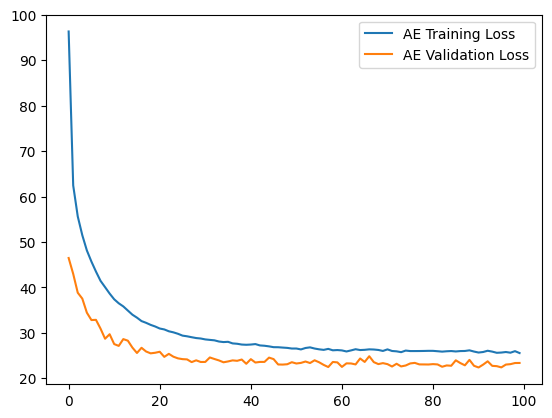

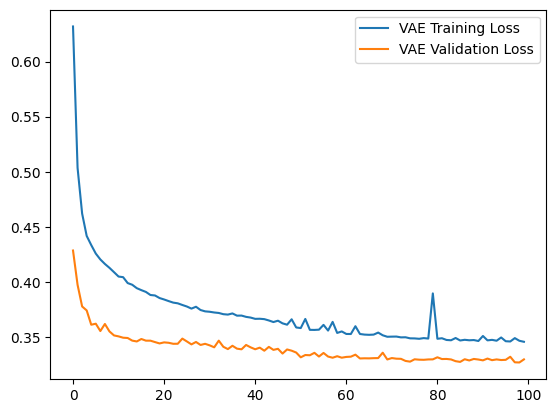

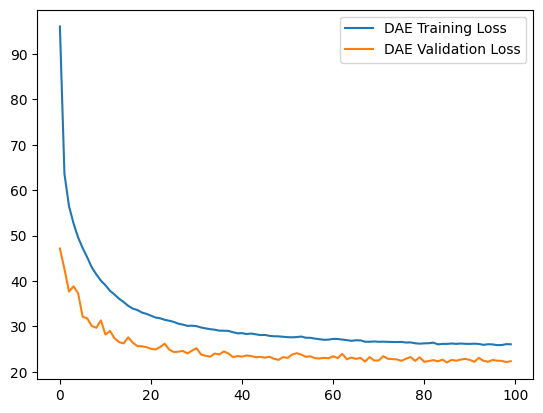

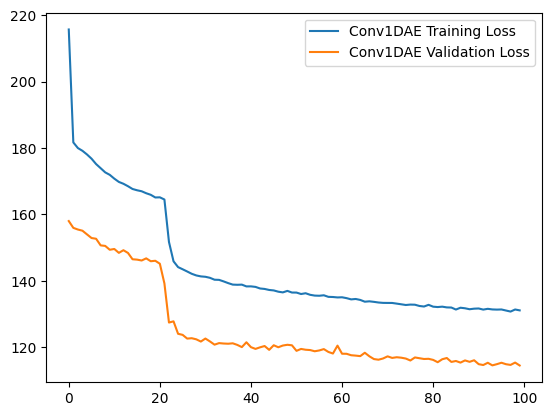

In [24]:
for res_key in results.keys():
    plt.plot(results[res_key]['train_losses'], label=f'{res_key} Training Loss')
    plt.plot(results[res_key]['val_losses'], label=f'{res_key} Validation Loss')
    plt.legend()
    plt.show()

In [25]:
print(f"Results Dictionary Keys:\n{results.keys()}")

Results Dictionary Keys:
dict_keys(['AE', 'VAE', 'DAE', 'Conv1DAE'])


In [31]:
print(f"Results Dictionary AE Keys:\n{results['AE'].keys()}\n")
print(f"Results Dictionary VAE Keys:\n{results['VAE'].keys()}\n")
print(f"Results Dictionary DAE Keys:\n{results['DAE'].keys()}\n")
print(f"Results Dictionary Conv1DAE Keys:\n{results['Conv1DAE'].keys()}\n")

Results Dictionary AE Keys:
dict_keys(['emb_df', 'df_latents', 'model', 'train_losses', 'val_losses'])

Results Dictionary VAE Keys:
dict_keys(['emb_df', 'df_latents', 'model', 'train_losses', 'val_losses'])

Results Dictionary DAE Keys:
dict_keys(['emb_df', 'df_latents', 'model', 'train_losses', 'val_losses'])

Results Dictionary Conv1DAE Keys:
dict_keys(['emb_df', 'df_latents', 'model', 'train_losses', 'val_losses'])



In [27]:
print(f"Results Dictionary AE emb_df:\n\n{results['AE']['emb_df']}\n\n")
print(f"Results Dictionary AE df_latents:\n\n{results['AE']['df_latents']}\n\n")
print(f"Results Dictionary AE model:\n\n{results['AE']['model']}\n\n")
print(f"Results Dictionary AE train_losses: {results['AE']['train_losses']}\n")
print(f"Results Dictionary AE val_losses: {results['AE']['val_losses']}\n")

Results Dictionary AE emb_df:

          umap1      umap2
0      1.459318   8.620425
1      5.388426  15.623631
2     -0.536116   2.256778
3      3.978138  16.554691
4     -1.413979   3.567289
...         ...        ...
44128 -3.166340  10.094526
44129 -3.558728  10.624835
44130 -0.656480   3.355989
44131 -1.223102  10.733652
44132  4.708696  15.055012

[44133 rows x 2 columns]


Results Dictionary AE df_latents:

              0         1         2         3         4         5         6  \
0     -1.188142 -0.862855  2.438377  0.288241  1.640511  0.822854  2.881811   
1      0.624731  0.502327  1.832736  0.041797  1.092451 -0.405139  1.712995   
2     -1.330819 -1.495574  0.083639  0.480567  1.871554  1.082001  0.859162   
3      0.613996 -0.316459  0.661059  0.144548  0.838430  1.251443 -0.002561   
4      1.545633 -2.300075  1.887710  0.558544  0.719048  0.657965  0.734140   
...         ...       ...       ...       ...       ...       ...       ...   
88261  0.598537 -0.555740  1.

In [28]:
print(f"Results Dictionary VAE emb_df:\n\n{results['VAE']['emb_df']}\n\n")
print(f"Results Dictionary VAE df_latents:\n\n{results['VAE']['df_latents']}\n\n")
print(f"Results Dictionary VAE model:\n\n{results['VAE']['model']}\n\n")
print(f"Results Dictionary VAE train_losses: {results['VAE']['train_losses']}\n")
print(f"Results Dictionary VAE val_losses: {results['VAE']['val_losses']}\n")

Results Dictionary VAE emb_df:

          umap1     umap2
0     -1.410746  6.513497
1      1.691335  7.365357
2      0.254331  9.795189
3      1.512341  6.745759
4      1.447263  7.361719
...         ...       ...
44128  0.502499  8.725250
44129  2.337662  8.127682
44130  1.313451  8.327485
44131 -1.836549  8.052472
44132  2.626144  5.766790

[44133 rows x 2 columns]


Results Dictionary VAE df_latents:

              0         1         2         3         4         5         6  \
0     -0.401987  1.637276  0.212182 -1.353418  0.835608  1.577846 -0.368246   
1     -0.735453  0.975276  0.395951  0.261567  0.367220 -0.344883  0.517695   
2     -0.987536  0.028493  0.191945 -0.405583 -1.113722  0.882923 -0.089712   
3     -1.198470 -0.499850  0.237576  1.155972  1.394384  0.234049 -1.338067   
4     -1.425387 -2.057980  0.237603 -0.595355 -0.472886 -0.450290  0.002141   
...         ...       ...       ...       ...       ...       ...       ...   
88261 -0.463312 -0.291940  1.170787  0.

In [29]:
print(f"Results Dictionary DAE emb_df:\n\n{results['DAE']['emb_df']}\n\n")
print(f"Results Dictionary DAE df_latents:\n\n{results['DAE']['df_latents']}\n\n")
print(f"Results Dictionary DAE model:\n\n{results['DAE']['model']}\n\n")
print(f"Results Dictionary DAE train_losses: {results['DAE']['train_losses']}\n")
print(f"Results Dictionary DAE val_losses: {results['DAE']['val_losses']}\n")

Results Dictionary DAE emb_df:

          umap1      umap2
0      0.202418  14.966916
1      9.089584  12.173490
2     -3.259372   6.128201
3      7.339785  14.098312
4     -3.084854   8.655629
...         ...        ...
44128  3.341622  10.728370
44129  4.026150  11.202042
44130 -1.858490   7.060077
44131  2.489702  13.311635
44132  9.138652  10.781366

[44133 rows x 2 columns]


Results Dictionary DAE df_latents:

              0         1         2         3         4         5         6  \
0     -1.233613  1.481460 -1.908916 -0.172176 -1.006464  0.318252  2.122463   
1      1.319098  0.306173 -0.135809 -0.830220  0.217423  1.004976  2.660828   
2      1.992520 -0.126348 -1.211802  0.248883  0.968422  0.271685  2.818175   
3      0.699367 -1.344700  1.511313  2.749962  0.888632 -0.515824  4.725359   
4     -1.093500  2.052635  1.338770  0.156953  0.652934 -0.824612  2.948572   
...         ...       ...       ...       ...       ...       ...       ...   
88261 -3.516970  3.046274  

In [30]:
print(f"Results Dictionary Conv1D AE emb_df:\n\n{results['Conv1DAE']['emb_df']}\n\n")
print(f"Results Dictionary Conv1D AE df_latents:\n\n{results['Conv1DAE']['df_latents']}\n\n")
print(f"Results Dictionary Conv1D AE model:\n\n{results['Conv1DAE']['model']}\n\n")
print(f"Results Dictionary Conv1D AE train_losses: {results['Conv1DAE']['train_losses']}\n")
print(f"Results Dictionary Conv1D AE val_losses: {results['Conv1DAE']['val_losses']}\n")

Results Dictionary Conv1D AE emb_df:

          umap1     umap2
0      0.420548  9.701002
1      0.102031  5.533131
2     -1.023024  8.518847
3     -0.856962  5.987799
4      0.304225  6.780609
...         ...       ...
44128 -1.973547  7.289195
44129 -2.401788  7.711985
44130 -1.183074  9.546004
44131 -1.965218  6.463149
44132 -0.322628  5.789794

[44133 rows x 2 columns]


Results Dictionary Conv1D AE df_latents:

              0         1         2         3         4         5         6  \
0      0.468831 -0.592429  1.028994  1.113261 -0.303818  1.284607  1.067008   
1      0.567592  0.602389  0.017071  0.464479 -1.461572  0.645001 -1.136285   
2     -0.239292 -0.505939 -0.945445 -0.722488 -0.731282  1.030267 -0.416480   
3     -0.921915 -1.366462 -1.372338  1.360746 -1.095479  1.947139 -0.791924   
4     -0.266198  0.072639 -0.867538  0.354555 -0.748779  1.009373 -0.201833   
...         ...       ...       ...       ...       ...       ...       ...   
88261  0.659595  0.008777  

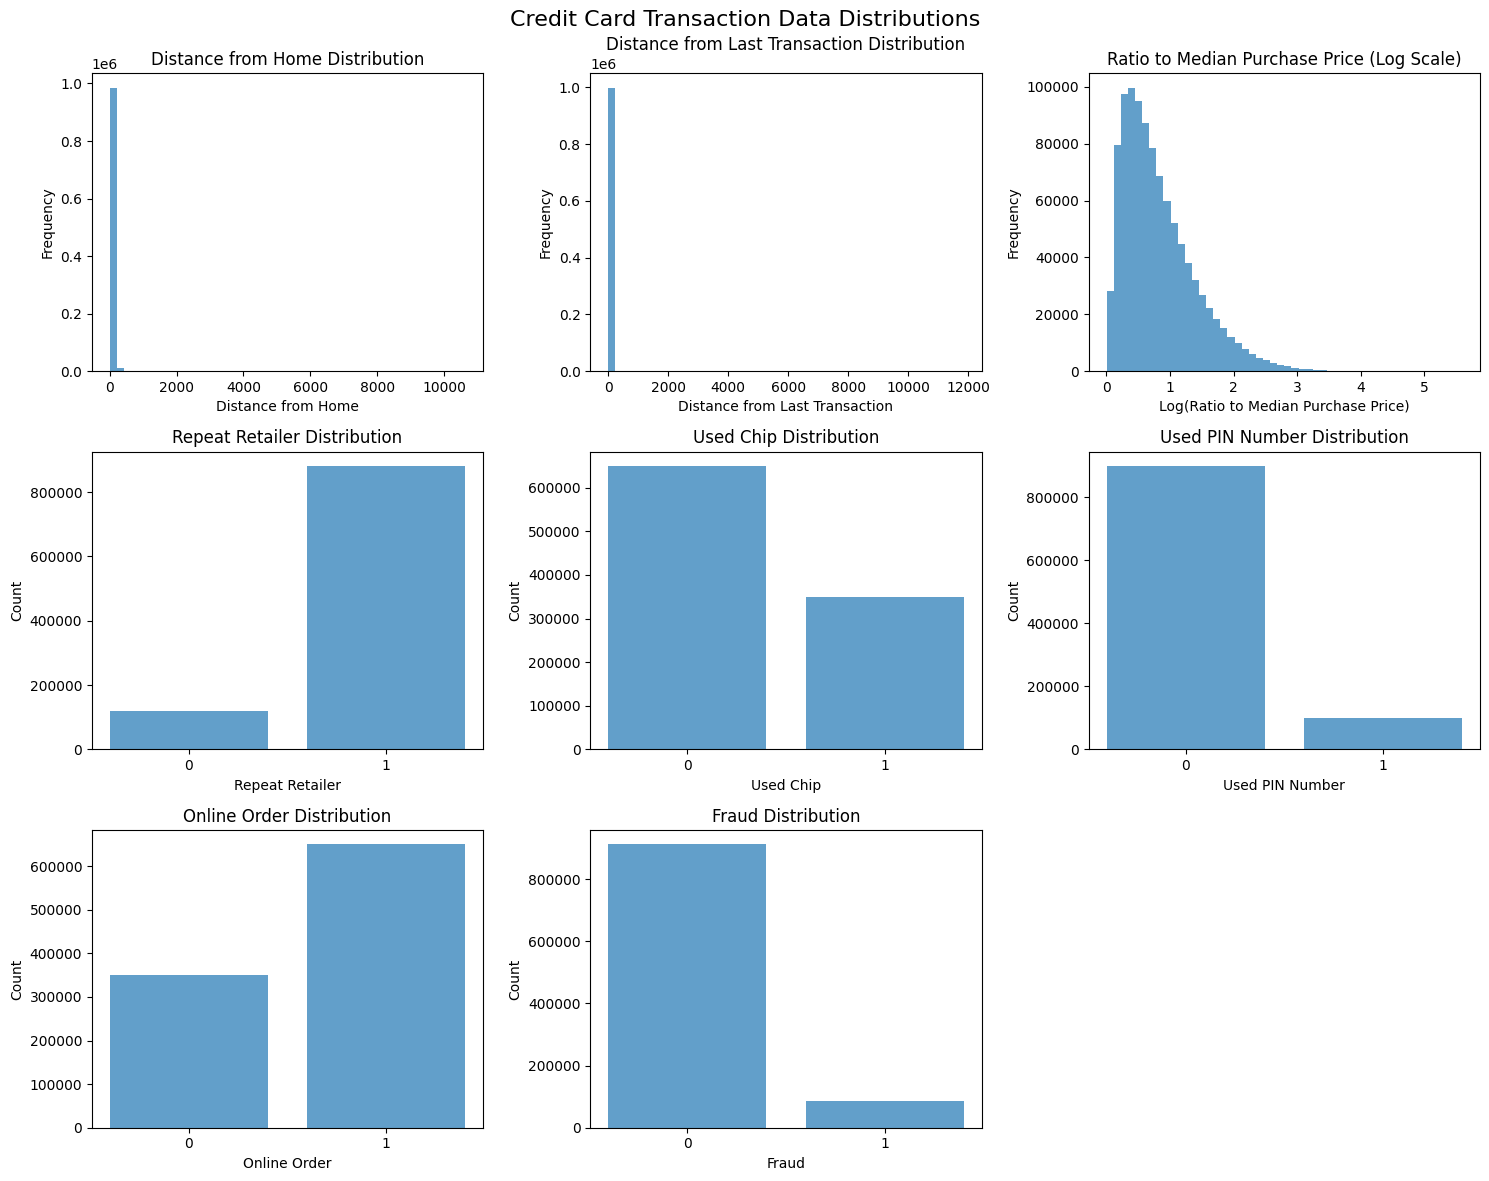

card dataframe corr:

                                distance_from_home  \
distance_from_home                        1.000000   
distance_from_last_transaction            0.000193   
ratio_to_median_purchase_price           -0.001374   
repeat_retailer                           0.143124   
used_chip                                -0.000697   
used_pin_number                          -0.001622   
online_order                             -0.001301   
fraud                                     0.187571   

                                distance_from_last_transaction  \
distance_from_home                                    0.000193   
distance_from_last_transaction                        1.000000   
ratio_to_median_purchase_price                        0.001013   
repeat_retailer                                      -0.000928   
used_chip                                             0.002055   
used_pin_number                                      -0.000899   
online_order                 

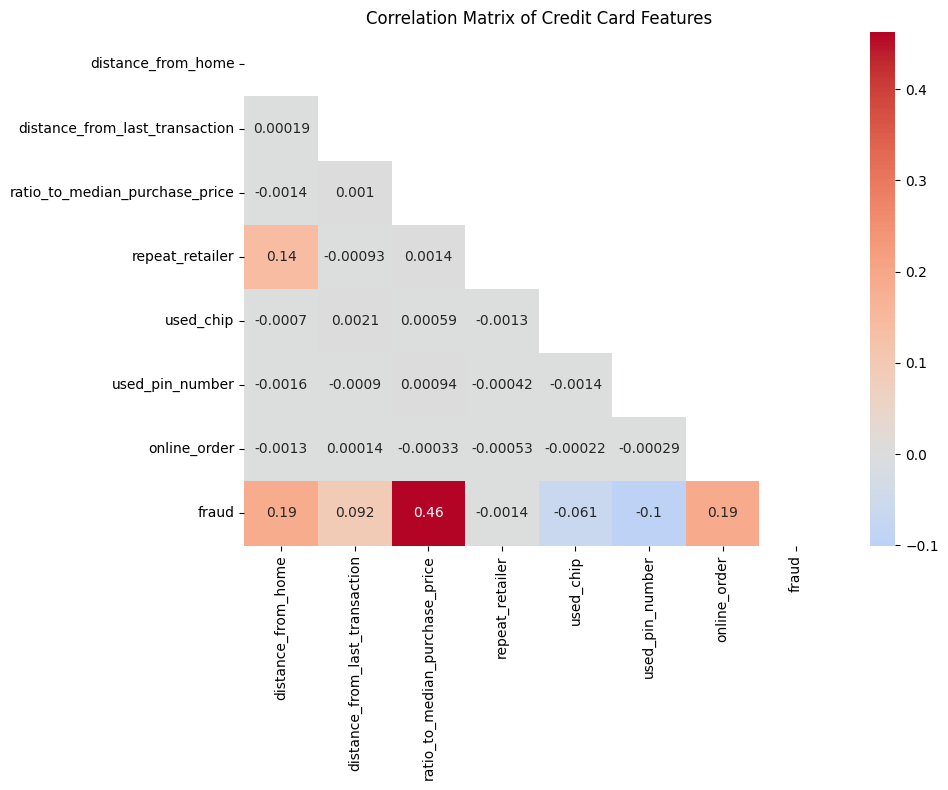

In [ ]:
card_df = pd.read_csv('card_transdata.csv')
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Credit Card Transaction Data Distributions', fontsize=16)

axes[0, 0].hist(card_df['distance_from_home'], bins=50, alpha=0.7)
axes[0, 0].set_xlabel('Distance from Home')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distance from Home Distribution')

axes[0, 1].hist(card_df['distance_from_last_transaction'], bins=50, alpha=0.7)
axes[0, 1].set_xlabel('Distance from Last Transaction')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distance from Last Transaction Distribution')

axes[0, 2].hist(np.log1p(card_df['ratio_to_median_purchase_price']), bins=50, alpha=0.7)
axes[0, 2].set_xlabel('Log(Ratio to Median Purchase Price)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Ratio to Median Purchase Price (Log Scale)')

repeat_counts = card_df['repeat_retailer'].value_counts()
axes[1, 0].bar(repeat_counts.index, repeat_counts.values, alpha=0.7)
axes[1, 0].set_xlabel('Repeat Retailer')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Repeat Retailer Distribution')
axes[1, 0].set_xticks([0, 1])

chip_counts = card_df['used_chip'].value_counts()
axes[1, 1].bar(chip_counts.index, chip_counts.values, alpha=0.7)
axes[1, 1].set_xlabel('Used Chip')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Used Chip Distribution')
axes[1, 1].set_xticks([0, 1])

pin_counts = card_df['used_pin_number'].value_counts()
axes[1, 2].bar(pin_counts.index, pin_counts.values, alpha=0.7)
axes[1, 2].set_xlabel('Used PIN Number')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Used PIN Number Distribution')
axes[1, 2].set_xticks([0, 1])

online_counts = card_df['online_order'].value_counts()
axes[2, 0].bar(online_counts.index, online_counts.values, alpha=0.7)
axes[2, 0].set_xlabel('Online Order')
axes[2, 0].set_ylabel('Count')
axes[2, 0].set_title('Online Order Distribution')
axes[2, 0].set_xticks([0, 1])

fraud_counts = card_df['fraud'].value_counts()
axes[2, 1].bar(fraud_counts.index, fraud_counts.values, alpha=0.7)
axes[2, 1].set_xlabel('Fraud')
axes[2, 1].set_ylabel('Count')
axes[2, 1].set_title('Fraud Distribution')
axes[2, 1].set_xticks([0, 1])

fig.delaxes(axes[2, 2])

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
corr = card_df.corr()
print(f"card dataframe corr:\n\n{corr}")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Credit Card Features')
plt.tight_layout()
plt.show()

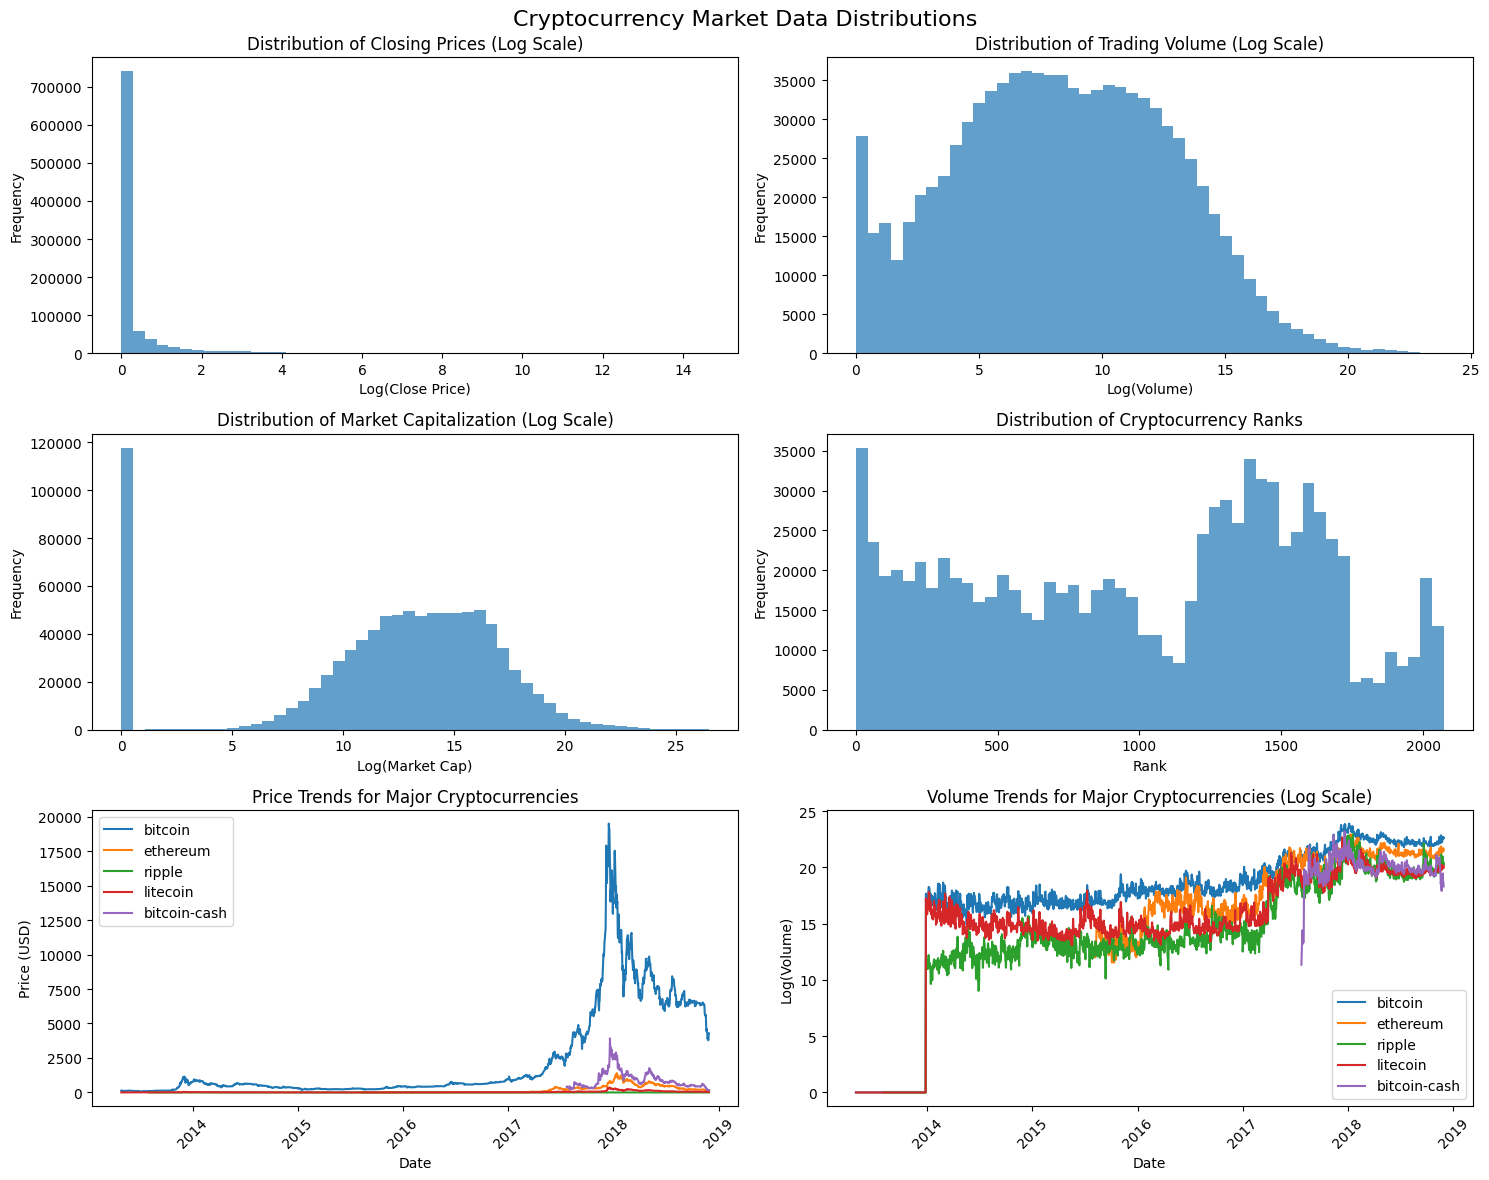

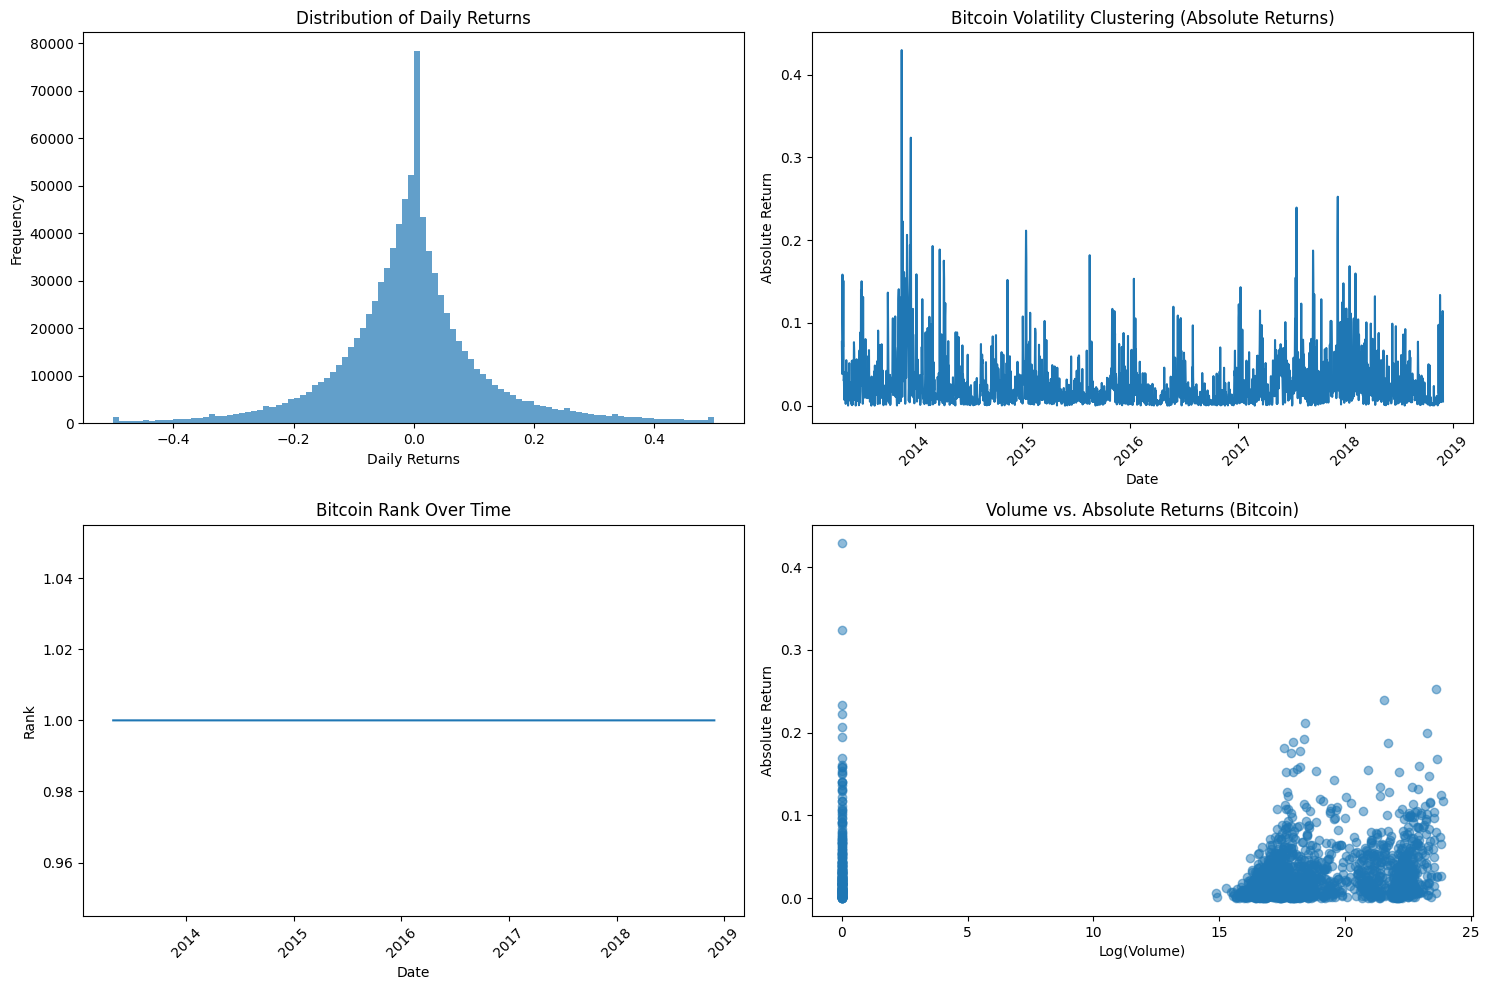

crypto numeric corr:

                 open      high       low     close    volume    market  \
open         1.000000  0.968123  0.971673  0.957178  0.011051  0.012543   
high         0.968123  1.000000  0.947305  0.971748  0.009241  0.010461   
low          0.971673  0.947305  1.000000  0.972246  0.012803  0.014673   
close        0.957178  0.971748  0.972246  1.000000  0.011124  0.012659   
volume       0.011051  0.009241  0.012803  0.011124  1.000000  0.880793   
market       0.012543  0.010461  0.014673  0.012659  0.880793  1.000000   
close_ratio -0.000631  0.000256  0.000875  0.003756  0.009710  0.010468   
spread       0.741319  0.856532  0.646075  0.749033  0.001392  0.001285   
ranknow      0.022624  0.022046  0.022721  0.022659 -0.077418 -0.080175   

             close_ratio    spread   ranknow  
open           -0.000631  0.741319  0.022624  
high            0.000256  0.856532  0.022046  
low             0.000875  0.646075  0.022721  
close           0.003756  0.749033  0.0

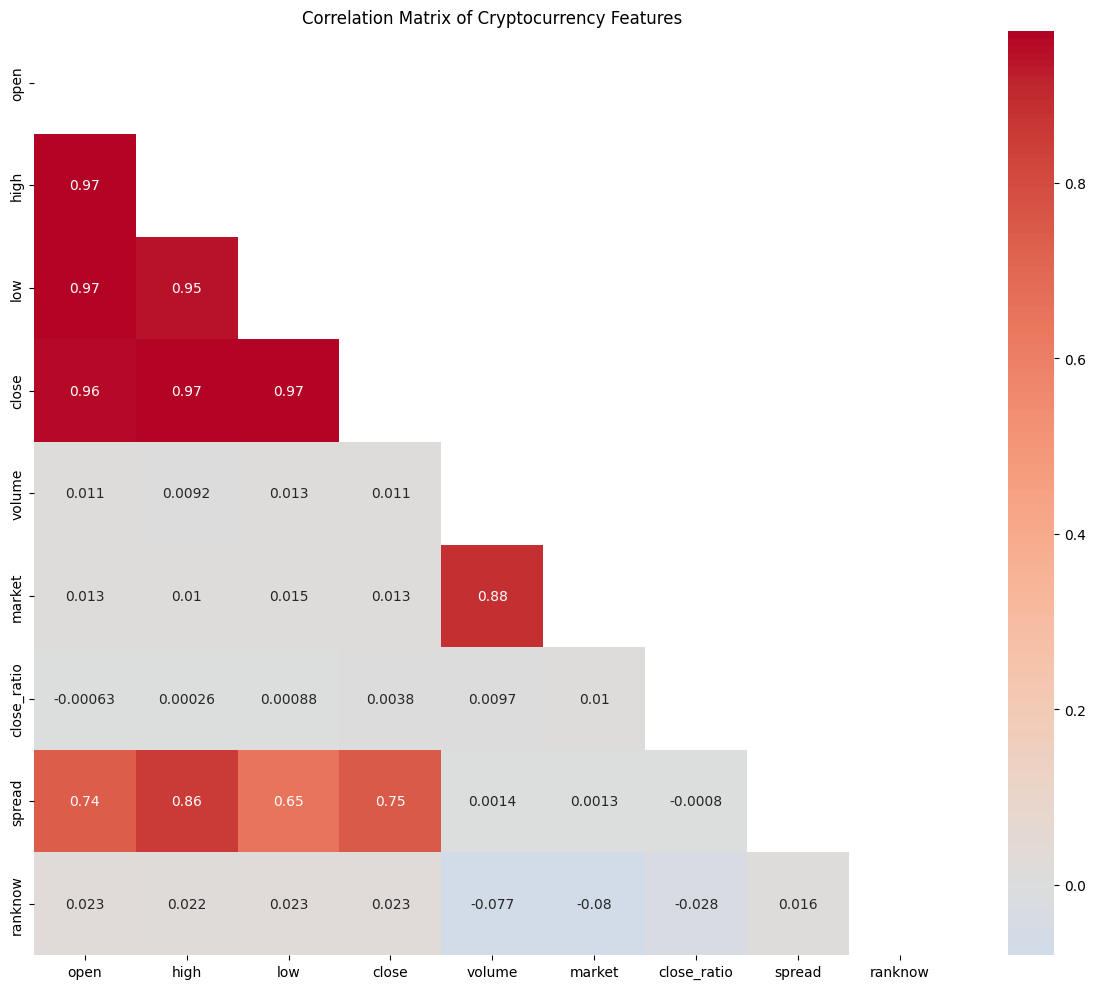

In [ ]:
crypto_df = pd.read_csv('crypto_markets.csv')
crypto_df['date'] = pd.to_datetime(crypto_df['date'])

major_cryptos = ['bitcoin', 'ethereum', 'ripple', 'litecoin', 'bitcoin-cash']
crypto_sample = crypto_df[crypto_df['slug'].isin(major_cryptos)]

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Cryptocurrency Market Data Distributions', fontsize=16)

axes[0, 0].hist(np.log1p(crypto_df['close']), bins=50, alpha=0.7)
axes[0, 0].set_xlabel('Log(Close Price)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Closing Prices (Log Scale)')

axes[0, 1].hist(np.log1p(crypto_df['volume']), bins=50, alpha=0.7)
axes[0, 1].set_xlabel('Log(Volume)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Trading Volume (Log Scale)')

axes[1, 0].hist(np.log1p(crypto_df['market']), bins=50, alpha=0.7)
axes[1, 0].set_xlabel('Log(Market Cap)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Market Capitalization (Log Scale)')

axes[1, 1].hist(crypto_df['ranknow'], bins=50, alpha=0.7)
axes[1, 1].set_xlabel('Rank')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Cryptocurrency Ranks')

for crypto in major_cryptos:
    crypto_data = crypto_sample[crypto_sample['slug'] == crypto]
    axes[2, 0].plot(crypto_data['date'], crypto_data['close'], label=crypto)
    
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('Price (USD)')
axes[2, 0].set_title('Price Trends for Major Cryptocurrencies')
axes[2, 0].legend()
axes[2, 0].tick_params(axis='x', rotation=45)

for crypto in major_cryptos:
    crypto_data = crypto_sample[crypto_sample['slug'] == crypto]
    axes[2, 1].plot(crypto_data['date'], np.log1p(crypto_data['volume']), label=crypto)
    
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Log(Volume)')
axes[2, 1].set_title('Volume Trends for Major Cryptocurrencies (Log Scale)')
axes[2, 1].legend()
axes[2, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

crypto_df['return'] = crypto_df.groupby('slug')['close'].pct_change()
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(crypto_df['return'].dropna(), bins=100, alpha=0.7, range=(-0.5, 0.5))
axes[0, 0].set_xlabel('Daily Returns')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Daily Returns')

btc_data = crypto_df[crypto_df['slug'] == 'bitcoin'].copy()
btc_data['abs_return'] = btc_data['return'].abs()
axes[0, 1].plot(btc_data['date'], btc_data['abs_return'])
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Absolute Return')
axes[0, 1].set_title('Bitcoin Volatility Clustering (Absolute Returns)')
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].plot(btc_data['date'], btc_data['ranknow'])
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Rank')
axes[1, 0].set_title('Bitcoin Rank Over Time')
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].scatter(np.log1p(btc_data['volume']), btc_data['abs_return'], alpha=0.5)
axes[1, 1].set_xlabel('Log(Volume)')
axes[1, 1].set_ylabel('Absolute Return')
axes[1, 1].set_title('Volume vs. Absolute Returns (Bitcoin)')

plt.tight_layout()
plt.show()

crypto_numeric = crypto_df[['open', 'high', 'low', 'close', 'volume', 'market', 'close_ratio', 'spread', 'ranknow']]
plt.figure(figsize=(12, 10))
corr = crypto_numeric.corr()
print(f"crypto numeric corr:\n\n{corr}\n")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Cryptocurrency Features')
plt.tight_layout()
plt.show()